## Get the data and check it.

In [1]:
# This command allows plots to appear in the jupyter notebook.
%matplotlib inline  
# Import the pandas package and load the json file into a dataframe called df.
import pandas as pd
df = pd.read_json('JEOPARDY_QUESTIONS1_cleaned.json')

In [2]:
pd.set_option('max_colwidth', 300)
df.head()

,air_date,answer,category,question,round,show_number,value
0,2004-12-31T00:00:00.000Z,Copernicus,HISTORY,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Jeopardy!,4680,200.0
1,2004-12-31T00:00:00.000Z,Jim Thorpe,ESPN's TOP 10 ALL-TIME ATHLETES,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jeopardy!,4680,200.0
10,2004-12-31T00:00:00.000Z,Jackie Gleason,EPITAPHS & TRIBUTES,"""And away we go""",Jeopardy!,4680,400.0
100,2010-07-06T00:00:00.000Z,a German Shepherd,JUST THE FACTS,This dog breed seen here is a loyal and protective companion,Double Jeopardy!,5957,1200.0
1000,2000-05-04T00:00:00.000Z,Vanessa Williams,MR. OR MS. WILLIAMS,This devoted mom has been called the most famous Miss America of all time,Double Jeopardy!,3619,2000.0


(Notice the fourth question about German Shepherd. This is the question that helped me find the regular expression error in my previous post.)

In [3]:
# Check the data types
df.dtypes

air_date        object
answer          object
category        object
question        object
round           object
show_number      int64
value          float64
dtype: object

In [4]:
# Let's convert air_date to date/time, rather than a string.
df['air_date'] = pd.to_datetime(df['air_date'], yearfirst= True)

In [5]:
df.dtypes

air_date       datetime64[ns]
answer                 object
category               object
question               object
round                  object
show_number             int64
value                 float64
dtype: object

In [6]:
# Make sure all the data is still there.
df.count()

air_date       216930
answer         216930
category       216930
question       216930
round          216930
show_number    216930
value          213296
dtype: int64

## State of Jeopardy

One thing I noticed when looking at the categories is that *geography* seems to be a recurring topic. Is there a way I can find a common theme among the geography questions? Since geography is a large topic, I decided to narrow my focus and only look at questions where the answer was a U.S. state. This is a well-defined set with a few ambiguities (which I will discuss later). 

In [7]:
# Geography is a common theme for Jeopardy categories.
category_counts = df['category'].value_counts() 
category_counts[:15]

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
Name: category, dtype: int64

In [8]:
list_of_states = ['Alabama','Alaska','Arizona','Arkansas','California', 
                  'Colorado','Connecticut', 'Delaware', 'Florida','Georgia',
                  'Hawaii','Idaho','Illinois','Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
                  'Michigan','Minnesota','Mississippi', 'Missouri','Montana','Nebraska', 
                  'Nevada','New Hampshire', 'New Jersey','New Mexico', 'New York',
                  'North Carolina', 'North Dakota','Ohio','Oklahoma', 'Oregon',
                  'Pennsylvania', 'Rhode Island','South Carolina', 'South Dakota',
                  'Tennessee','Texas','Utah','Vermont', 'Virginia', 'Washington', 
                  'West Virginia', 'Wisconsin', 'Wyoming']
len(list_of_states)

50

In [9]:
# Create new dataframe with only states as answers.
state_answers = df[df['answer'].isin(list_of_states)]

In [10]:
# How many of the original data set questions have U.S. states as an answer?
x = df['question'].count()
y = state_answers['question'].count()
print "Total :", x
print "States:", y
print "Percentage:", float(y)/float(x)

Total : 216930
States: 3893
Percentage: 0.0179458811598


In [11]:
# How does this compare to the number of questions in the most popular category "BEFORE & AFTER"?
z = df[df['category']=='BEFORE & AFTER']['question'].count()
print z
print float(z)/float(x)

547
0.00252155073065


About .2% of the questions in the dataset are from the BEFORE & AFTER category. This is small compared to the number of questions where a U.S. state is the answer, 2%. Let's take a look at these questions about U.S. states.

## California is most likely to appear as a Jeopardy answer about a U.S. state. 

In [12]:
# Count up how many answers there are for each state. Sort them and print last few.
count_state_answers = state_answers.answer.value_counts()
count_state_answers.sort_values().tail()

Florida       140
Texas         153
Hawaii        157
Alaska        161
California    180
Name: answer, dtype: int64

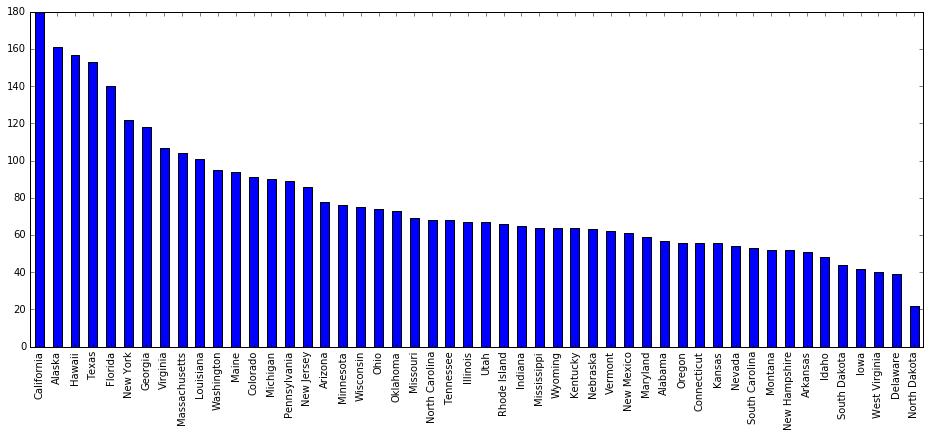

In [13]:
# Let's plot the counts too.
#fig, ax = plt.subplots(2,1,figsize=(14,6),sharex=True)

count_state_answers.plot(kind='bar', figsize=(16,6));

Certain states are more likely to appear in a Jeopardy question. Why is that? 

My first thought was that it's somehow related to population. The most populous states in the U.S. are California, Texas, and Florida. But, Alaska and Hawaii are the 11th and 3rd *least* populous states. Population doesn't appear to track with a state's popularity on Jeopardy, but it seems somewhat related. I'll look into this a bit more with another metric, but first let's see if there's a correlation between the popularity of a state on Jeopardy and its dollar amount. 


## There is no relationship between a state's popularity and its dollar value.

* Should a contestant study the states that appear the most frequently? 

OR
* Should they study the states that appear less frequently because their dollar amounts are higher than the more popular states?

To answer this question (and other later questions), I'll create a new dataframe (`state_data`) that contains  information about each state's questions, as opposed to the dataframe I'm using now (`state_answers`) which is organized by question.

In [14]:
# Group the states' answers by their values and 
# find the mean and standard deviation of the values.
avg_values = state_answers.groupby('answer')['value'].mean()
std_values = state_answers.groupby('answer')['value'].std()

In [15]:
# Put state data together in a single dataframe.
state_data = pd.concat([count_state_answers, avg_values, std_values], axis = 1)
state_data.columns = ['total_count', 'value_avg','value_std' ]
state_data.head()

,total_count,value_avg,value_std
Alabama,57,771.929825,646.350852
Alaska,161,673.417722,501.007612
Arizona,78,912.820513,649.946846
Arkansas,51,844.897959,721.416784
California,180,632.222222,518.771169


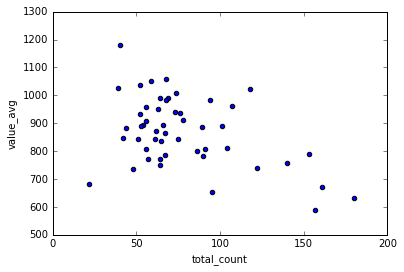

In [16]:
# Plot the relationship between average dollar value and total number of appearances on Jeopardy.
state_data.plot(x='total_count', y='value_avg',  kind = 'scatter');

The plot above might seem to indicate that more frequently occurring states (***large*** `total_count` values) have a smaller average dollar value. But adjusting the y-range and including the standard deviation of the points shows that there really isn't a correlation between the frequency and dollar amount.

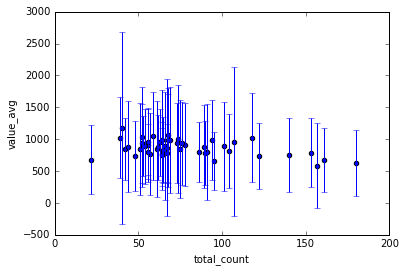

In [17]:
state_data.plot(x='total_count', y='value_avg', yerr ='value_std',  kind = 'scatter');

## There is no evolution in time of the popularity of states. 

It doesn't seem like there is a relationship between the frequency of a state's appearance and its dollar value. Perhaps there is some evolution with time which is introducing scatter in the data. Or perhaps the incomplete data in some years is also a factor.

Let me first only look at data from years where the data seems complete and then compare the data for those years.

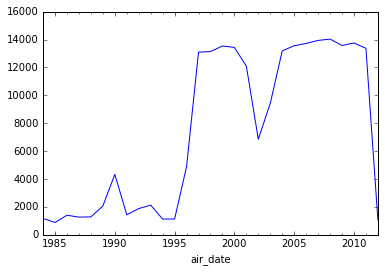

In [18]:
# Count up data Annually, "A"
df.resample('A', on='air_date')['question'].count().plot();

In [19]:
# Let's remove years where the data is not well sampled. 
# I'm going to assume the years 2004-201 are complete.
df_years = df[(df['air_date']>='2004-01-01') & (df['air_date']<='2011-12-31')]

In [20]:
# Find answers that are states in this new time-limited dataframe. 
state_answers_years = df_years[df_years['answer'].isin(list_of_states)]
count_state_answers_years = state_answers_years.answer.value_counts()
avg_values_years = state_answers_years.groupby('answer')['value'].mean()
std_values_years = state_answers_years.groupby('answer')['value'].std()
# Put state data together in a new dataframe.
state_data_years = pd.concat([count_state_answers_years, avg_values_years, std_values_years], axis = 1)
state_data_years.columns = ['total_count', 'value_avg','value_std' ]

In [21]:
state_data_years.head()

,total_count,value_avg,value_std
Alabama,32,781.250000,506.370704
Alaska,75,687.837838,555.409932
Arizona,44,877.272727,610.323451
Arkansas,20,800.000000,433.860916
California,92,606.521739,423.954266


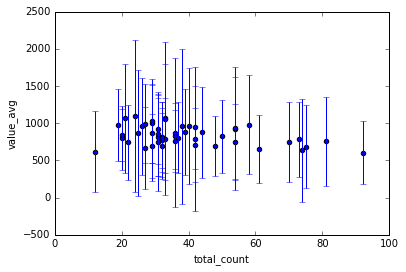

In [22]:
state_data_years.plot(x='total_count', y='value_avg', yerr ='value_std',  kind = 'scatter');

Removing the data for the poorly-sampled years didn't seem to change the result. So let's look at whether there's a relationship with years. To do this, I'll update the `state_data` dataframe with information for each year.

In [23]:
start_year = 2004
end_year = 2012
increment = 1
years = range(start_year, end_year, increment)
for year in years:
    start_date = str(str(year)+'-01-01')
    end_date = str(str(year)+'-12-31')
# Create a dataframe for the current year, compiling counts for that year for each state.
    df_year = pd.DataFrame(state_answers_years[(state_answers_years['air_date'] >= start_date)
                           &(state_answers_years['air_date'] <= end_date)].groupby
                           ('answer')['question'].count().astype(float))
    df_year.columns = [str(year)]
    state_data_years = state_data_years.join(df_year, how = 'outer')

state_data_years.head()

,total_count,value_avg,value_std,2004,2005,2006,2007,2008,2009,2010,2011
Alabama,32,781.250000,506.370704,1.0,8.0,NaN,1.0,6.0,7.0,3.0,6.0
Alaska,75,687.837838,555.409932,8.0,10.0,9.0,13.0,8.0,11.0,8.0,8.0
Arizona,44,877.272727,610.323451,5.0,4.0,3.0,5.0,4.0,6.0,9.0,8.0
Arkansas,20,800.000000,433.860916,1.0,2.0,3.0,4.0,4.0,2.0,2.0,2.0
California,92,606.521739,423.954266,14.0,10.0,11.0,18.0,11.0,5.0,11.0,12.0


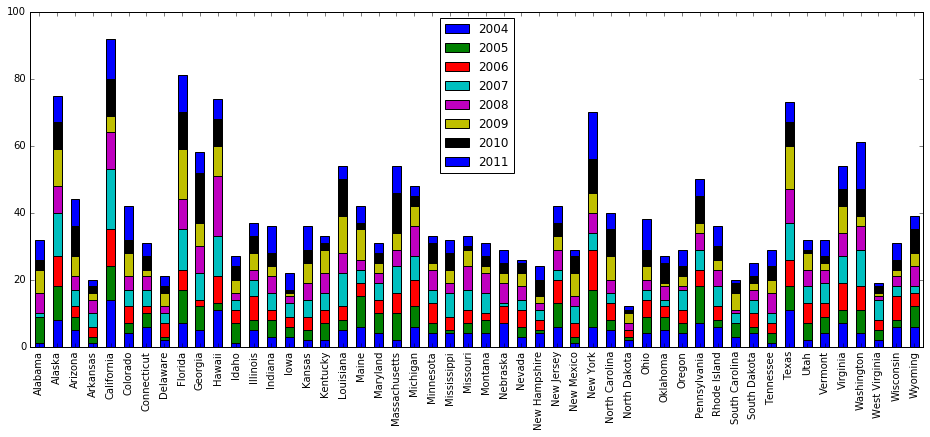

In [24]:
# Create a plot showing the number of appearances of each state, grouped by year.
ignore_colums = ['total_count', 'value_avg', 'value_std']
state_data_years.ix[:,state_data_years.columns.difference(ignore_colums)].plot.bar(
    stacked=True, figsize=(16,6));

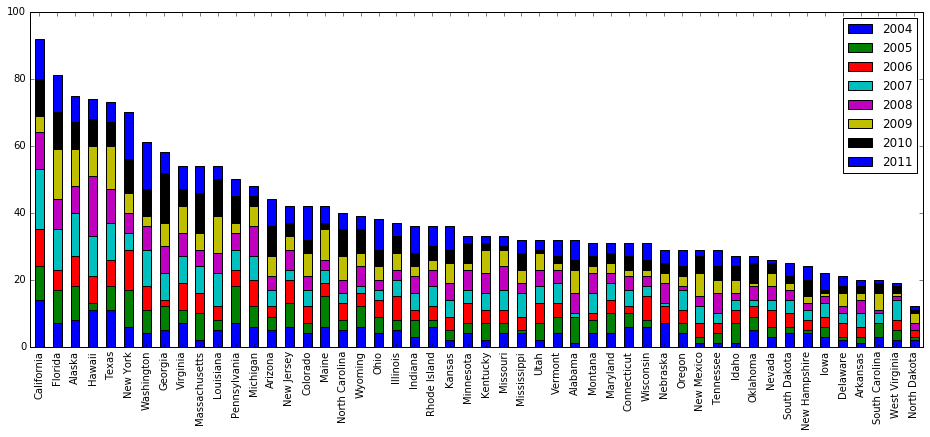

In [25]:
# Let's sort these by the total count for each state.
sorted_by_count = state_data_years['total_count'].sort_values(ascending=False)
state_data_years.ix[:,state_data_years.columns.difference(ignore_colums)].reindex(
    index = sorted_by_count.keys()).plot.bar(stacked=True, figsize=(16,6));

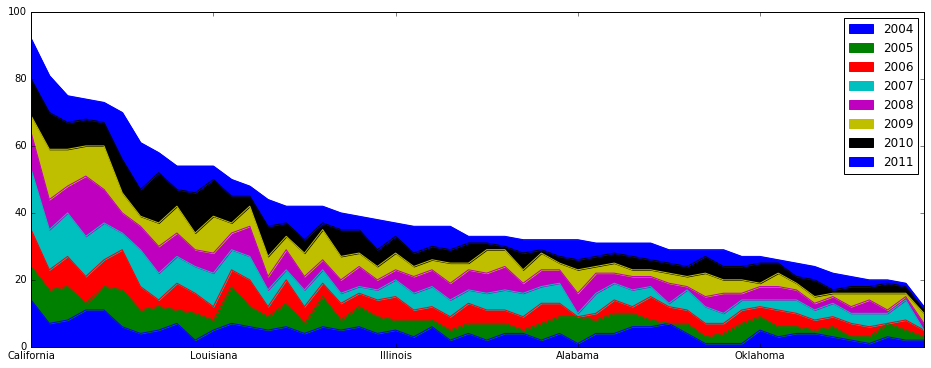

In [26]:
# Here's another way to view this which is a little nicer. 
state_data_years.ix[:,state_data_years.columns.difference(ignore_colums)].reindex(
    index = sorted_by_count.keys()).plot.area(figsize=(16,6));

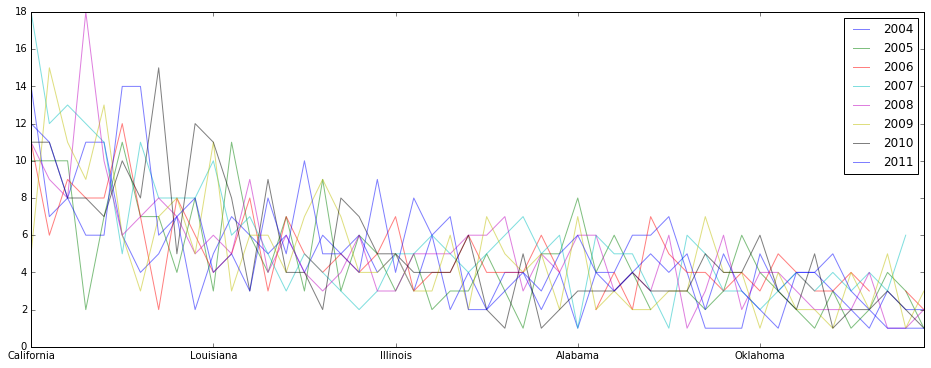

In [27]:
# What if I plot each year individually? Do certain years stick out?
state_data_years.ix[:,state_data_years.columns.difference(ignore_colums)].reindex(
    index = sorted_by_count.keys()).plot(alpha = 0.5, figsize=(16,6));

There doesn't seem to be a relationship with year for the frequency of different states. It all seems fairly random, following the same general downward trend.

I can investigate this in more depth by comparing the counts for each state from one year to another.

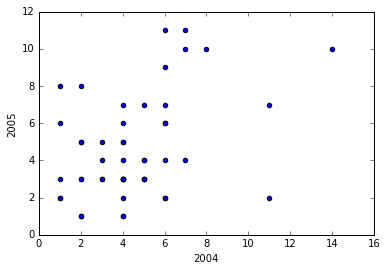

In [28]:
# Here is a plot showing the number of appearances for each state for two years, 2004 and 2005.
state_data_years.plot(x='2004', y='2005',  kind = 'scatter');

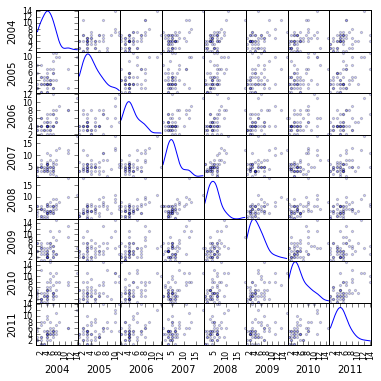

In [29]:
# Pandas allows you to do this year-to-year comparison for all years at once. 
# There is a slight upward trend in all of them.
from pandas.tools.plotting import scatter_matrix
scatter_matrix(state_data_years.ix[:,state_data_years.columns.difference(ignore_colums)], 
               alpha=0.2, figsize=(6, 6), diagonal='kde');

In [30]:
# You can also calculate how correlated the years are to each other numerically.
state_data_years.ix[:,state_data_years.columns.difference(ignore_colums)].corr()

,2004,2005,2006,2007,2008,2009,2010,2011
2004,1.000000,0.405445,0.621104,0.636811,0.663744,0.382158,0.460871,0.413987
2005,0.405445,1.000000,0.520428,0.389909,0.351686,0.397216,0.489598,0.551795
2006,0.621104,0.520428,1.000000,0.517778,0.538095,0.399517,0.356237,0.552967
2007,0.636811,0.389909,0.517778,1.000000,0.645156,0.511134,0.558315,0.507065
2008,0.663744,0.351686,0.538095,0.645156,1.000000,0.525347,0.475345,0.385116
2009,0.382158,0.397216,0.399517,0.511134,0.525347,1.000000,0.468341,0.332316
2010,0.460871,0.489598,0.356237,0.558315,0.475345,0.468341,1.000000,0.563157
2011,0.413987,0.551795,0.552967,0.507065,0.385116,0.332316,0.563157,1.000000


Numbers between 0 and +1 are positively correlated. The closer the correlation coefficient is to +1, the more correlated the years. So, the years are slightly correlated to one another, which agrees with the scatter plots above. If anything, this tells me that I don't need to worry much about the data changing over the years; I don't have to separate the data out by years.